# Final Project: Sentiment Analysis on Covid-19 Tweets  
**Math189Z – Covid-19: Data Analytics and Machine Learning**  
Nico Espinosa Dice  
*May, 2020*  

## Sources
This project uses theory presented in the following academic papers:  
- [Sentiment Analysis of Twitter Data](http://www.cs.columbia.edu/~julia/papers/Agarwaletal11.pdf) (1)

- [Sentiment Analysis of Twitter Data](https://arxiv.org/pdf/1711.10377.pdf) (2)

- [Covid-19 Tweets Dataset and Statistics](https://ieee-dataport.org/open-access/corona-virus-covid-19-tweets-dataset)


This project uses code that was inspired and adapted from the following open-source resources:  
- [Twitter Sentiment Analysis with Explanation (Naive Bayes)](https://medium.com/@koshut.takatsuji/twitter-sentiment-analysis-with-full-code-and-explanation-naive-bayes-a380b38f036b)

- [Creating The Twitter Sentiment Analysis Program in Python with Naive Bayes Classification](https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed)

- [How to Do Sentiment Analysis on a Twitter Account](https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082)

- [Comprehensive Hands on Guide to Twitter Sentiment Analysis with dataset and code](https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/)

### Data
The dataset of Tweets was provided by Professor Gu as part of HMC Math189Z. The data is available [here](https://math189covid19.github.io/resources.html). The original source of the data is unknown at this time.

The Twitter sentiment corpus was downloaded from this [public repository](https://github.com/zfz/twitter_corpus).

## Importing Data

In [1]:
# Imports the necessary libraries
import numpy as np
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicoespinosadice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nicoespinosadice/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# # For aesthetic purposes
# # Source: https://stackoverflow.com/a/46884966
# params = {"figure.facecolor": "#cad9e1",
#               "axes.facecolor": "#cad9e1",
#               "axes.grid" : True,
#               "axes.grid.axis" : "y",
#               "grid.color"    : "#ffffff",
#               "grid.linewidth": 2,
#               "axes.spines.left" : False,
#               "axes.spines.right" : False,
#               "axes.spines.top" : False,
#               "ytick.major.size": 0,     
#               "ytick.minor.size": 0,
#               "xtick.direction" : "in",
#               "xtick.major.size" : 7,
#               "xtick.color"      : "#191919",
#               "axes.edgecolor"    :"#191919",
#               "axes.prop_cycle" : plt.cycler('color',
#                                     ['#006767', '#ff7f0e', '#2ca02c', '#d62728',
#                                      '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
#                                      '#bcbd22', '#17becf'])}
# plt.rcParams.update(params)

In [3]:
# Imports data into Pandas dataframe
feb_tweets = pd.read_csv('Data/feb_data.csv')
march_tweets = pd.read_csv('Data/march_data.csv')
april_tweets = pd.read_csv('Data/april_data.csv')

In [4]:
# Sets column names of dataframes and drop unnecessary column
feb_tweets.columns, march_tweets.columns, april_tweets.columns = ['Number', "Date", "Text"], ['Number', "Date", "Text"], ['Number', "Date", "Text"]
feb_tweets = feb_tweets.drop(columns = ["Number"])
march_tweets = march_tweets.drop(columns = ["Number"])
april_tweets = april_tweets.drop(columns = ["Number"])

In [5]:
feb_tweets["Month"] = "February"
march_tweets["Month"] = "March"
april_tweets["Month"] = "April"

data = pd.concat([feb_tweets, march_tweets, april_tweets], ignore_index=True)

## Exploratory Data Analysis

In [6]:
feb_tweets.head()

,Date,Text,Month
0,2020-02-19 23:59:11,Head nurse Cai Liping of Wuchang Hospital died...,February
1,2020-02-19 23:59:00,This bacteria-killing UV light robot helps a W...,February
2,2020-02-19 23:56:52,For those that are into the business side of s...,February
3,2020-02-19 23:55:34,How to fight against #coronavirus in #japan,February
4,2020-02-19 23:53:03,Diseases like covid-19 are deadlier in non-dem...,February


In [7]:
data.tail()

,Date,Text,Month
7495,2020-04-04 16:57:39,"BREAKING: New York ""Accidentally"" Delivered Co...",April
7496,2020-04-04 16:57:32,With fewer people around because of #coronavir...,April
7497,2020-04-04 16:56:46,If Joe Biden is talking about the Trump Admini...,April
7498,2020-04-04 16:56:41,"In case you know anyone looking for a job, Par...",April
7499,2020-04-04 16:56:13,Atleast now we all know where Lisbon got its c...,April


## Data Preprocessing

### Data Cleaning

In [8]:
new_stopwords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL'])

In [9]:
# "cleans" the text by removing hyperlinks, hashtags, mentions, and retweets
# This function was suggested here: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082
def cleanText(text):
    text = text.lower() # Makes text lowercase
    text = re.sub('https?:\/\/\S+', '', text) # Removes hyperlinks
    text = re.sub('#', '', text) # Removes hashtags
    text = re.sub('@[A-Za-z0–9]+', '', text) # Removes mentions (@)
    text = re.sub('RT[\s]+', '', text) # Removes "RT"
    return text

In [10]:
def convertToList(text):
    text = word_tokenize(text)
    return [word for word in text if word not in new_stopwords] # Source for this line: https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed

In [11]:
# Applys cleanText() to every Tweet in dataframe
data["Text"] = data["Text"].apply(cleanText)
data["List of Words"] = data["Text"].apply(convertToList)

In [12]:
data.head()

,Date,Text,Month,List of Words
0,2020-02-19 23:59:11,head nurse cai liping of wuchang hospital died...,February,"[head, nurse, cai, liping, wuchang, hospital, ..."
1,2020-02-19 23:59:00,this bacteria-killing uv light robot helps a w...,February,"[bacteria-killing, uv, light, robot, helps, wu..."
2,2020-02-19 23:56:52,for those that are into the business side of s...,February,"[business, side, sneakers, adidas, business, r..."
3,2020-02-19 23:55:34,how to fight against coronavirus in japan,February,"[fight, coronavirus, japan]"
4,2020-02-19 23:53:03,diseases like covid-19 are deadlier in non-dem...,February,"[diseases, like, covid-19, deadlier, non-democ..."


## Feature Engineering

### Polarity
-1 → extreme negative,  
0 → neutral,  
1 → extreme positive.

In [13]:
# Returns the polarity of the Tweet's text
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity

In [14]:
# Creates a new column containing the subjectivity of every Tweet
data['Polarity'] = data['Text'].apply(getPolarity)

### Subjectivity
0 → fact,  
1 → opinion.

In [15]:
# Returns the subjectivity of the Tweet's text
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

In [16]:
# Creates a new column containing the subjectivity of every Tweet
data["Subjectivity"] = data["Text"].apply(getSubjectivity)

## Sentiment Analysis
Polarity < 0 → negative,  
Polarity == 0 → neutral,  
Polarity > 0 → positive. 

In [17]:
# Returns the analysis of each Tweet's text
def getSentiment(polarity):
    if polarity < 0:
      return 'Negative'
    elif polarity == 0:
      return 'Neutral'
    else:
      return 'Positive'

In [18]:
data['Analysis'] = data['Polarity'].apply(getSentiment)

In [19]:
data.head()

,Date,Text,Month,List of Words,Polarity,Subjectivity,Analysis
0,2020-02-19 23:59:11,head nurse cai liping of wuchang hospital died...,February,"[head, nurse, cai, liping, wuchang, hospital, ...",0.000000,0.095833,Neutral
1,2020-02-19 23:59:00,this bacteria-killing uv light robot helps a w...,February,"[bacteria-killing, uv, light, robot, helps, wu...",0.400000,0.700000,Positive
2,2020-02-19 23:56:52,for those that are into the business side of s...,February,"[business, side, sneakers, adidas, business, r...",-0.126852,0.354630,Negative
3,2020-02-19 23:55:34,how to fight against coronavirus in japan,February,"[fight, coronavirus, japan]",0.000000,0.000000,Neutral
4,2020-02-19 23:53:03,diseases like covid-19 are deadlier in non-dem...,February,"[diseases, like, covid-19, deadlier, non-democ...",0.627500,0.832500,Positive


## Analysis

### Analysis: Full Dataset

In [20]:
positive_tweets = data.loc[data["Analysis"] == "Positive"]
neutral_tweets = data.loc[data["Analysis"] == "Neutral"]
negative_tweets = data.loc[data["Analysis"] == "Negative"]

In [21]:
positive_tweets.reset_index(drop=True, inplace=True)
neutral_tweets.reset_index(drop=True, inplace=True)
negative_tweets.reset_index(drop=True, inplace=True)

In [22]:
positive_tweets.head()

,Date,Text,Month,List of Words,Polarity,Subjectivity,Analysis
0,2020-02-19 23:59:00,this bacteria-killing uv light robot helps a w...,February,"[bacteria-killing, uv, light, robot, helps, wu...",0.4000,0.7000,Positive
1,2020-02-19 23:53:03,diseases like covid-19 are deadlier in non-dem...,February,"[diseases, like, covid-19, deadlier, non-democ...",0.6275,0.8325,Positive
2,2020-02-19 23:47:07,the world's most comprehensive site addressing...,February,"[world, 's, comprehensive, site, addressing, a...",0.5000,0.5000,Positive
3,2020-02-19 23:39:10,". ""12,000 people have died from influenza betw...",February,"[``, 12,000, people, died, influenza, oct., 1,...",0.1600,0.5400,Positive
4,2020-02-19 23:35:51,coronavirus chaos can prompt a needed rethink ...,February,"[coronavirus, chaos, prompt, needed, rethink, ...",0.1000,0.1000,Positive


In [23]:
neutral_tweets["Text"].head()

0    head nurse cai liping of wuchang hospital died...
1            how to fight against coronavirus in japan
2    indonesian mfa is pressuring japanese authorit...
3    someone on nm senate floor just asked if "coro...
4    "open access epidemiological data from the cov...
Name: Text, dtype: object

In [24]:
negative_tweets.head()

,Date,Text,Month,List of Words,Polarity,Subjectivity,Analysis
0,2020-02-19 23:56:52,for those that are into the business side of s...,February,"[business, side, sneakers, adidas, business, r...",-0.126852,0.354630,Negative
1,2020-02-19 23:50:35,infectivity 60% those who need hospital care 1...,February,"[infectivity, 60, need, hospital, care, 15, 2,...",-0.482143,0.628571,Negative
2,2020-02-19 23:48:44,im rly annoyed with coronavirus racism my frie...,February,"[im, rly, annoyed, coronavirus, racism, friend...",-0.104762,0.176190,Negative
3,2020-02-19 23:47:27,"""one flu is bad enough. a second flu would be ...",February,"[``, one, flu, bad, enough, second, flu, would...",-0.201477,0.575455,Negative
4,2020-02-19 23:41:43,to all the xbots that couldn’t control your fa...,February,"[xbots, ’, control, fanboyism, coronavirus, th...",-0.200000,0.800000,Negative


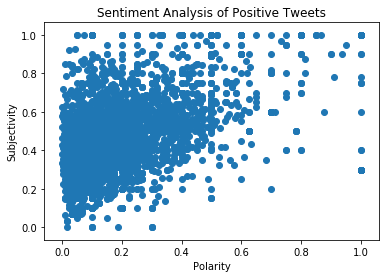

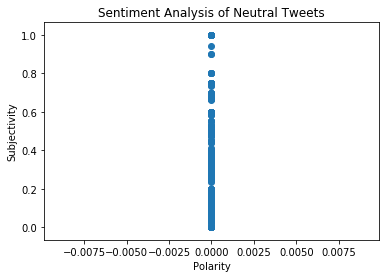

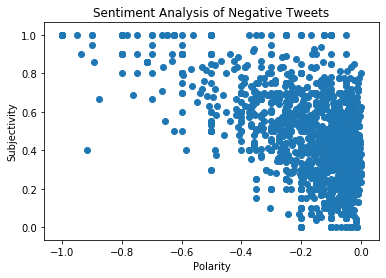

In [25]:
# Positive Tweets
plt.scatter(positive_tweets["Polarity"], positive_tweets["Subjectivity"])

plt.title('Sentiment Analysis of Positive Tweets') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

# Neutral Tweets
plt.scatter(neutral_tweets["Polarity"], neutral_tweets["Subjectivity"])

plt.title('Sentiment Analysis of Neutral Tweets') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity') 
plt.show()

# Negative Tweets
plt.scatter(negative_tweets["Polarity"], negative_tweets["Subjectivity"])

plt.title('Sentiment Analysis of Negative Tweets') 
plt.xlabel('Polarity') 
plt.ylabel('Subjectivity')
plt.show()

In [26]:
print(data["Analysis"].value_counts())
print("Total:", data.shape[0])
print()

print("Percentage of positive Tweets:", (positive_tweets.shape[0] / data.shape[0]))
print()

print("Percentage of neutral Tweets:", (neutral_tweets.shape[0] / data.shape[0]))
print()

print("Percentage of negative Tweets:", (negative_tweets.shape[0] / data.shape[0]))

Positive    3417
Neutral     2265
Negative    1818
Name: Analysis, dtype: int64
Total: 7500

Percentage of positive Tweets: 0.4556

Percentage of neutral Tweets: 0.302

Percentage of negative Tweets: 0.2424


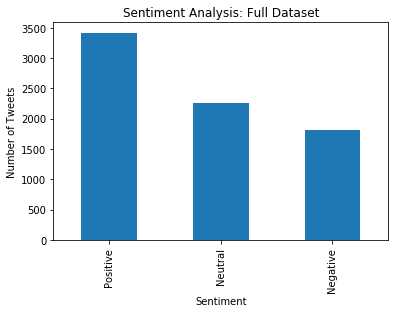

In [27]:
plt.title("Sentiment Analysis: Full Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
data["Analysis"].value_counts().plot(kind = "bar")
plt.show()

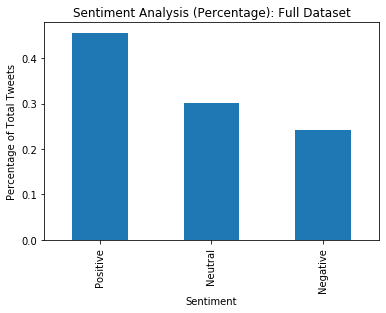

In [28]:
plt.title("Sentiment Analysis (Percentage): Full Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Percentage of Total Tweets")
((data["Analysis"].value_counts())/data.shape[0]).plot(kind = "bar")
plt.show()

### Analysis: Monthly

In [29]:
months = list(dict.fromkeys(data["Month"].values))
sentiments = list(dict.fromkeys(data["Analysis"].values))
sentiment_colors = {"Positive": "Blue", "Negative": "Red", "Neutral": "Gray"}

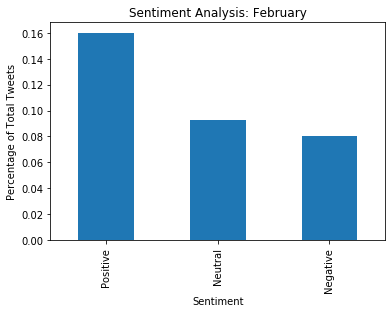

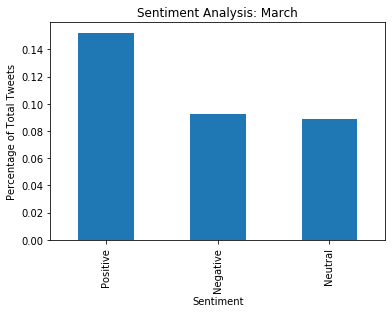

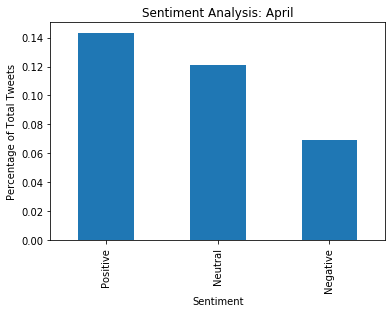

In [30]:
for month in months:
    month_tweets = data.loc[data["Month"] == month]
    plt.title("Sentiment Analysis: " + month)
    plt.xlabel("Sentiment")
    plt.ylabel("Percentage of Total Tweets")
    ((month_tweets["Analysis"].value_counts())/data.shape[0]).plot(kind = 'bar')
    plt.show()

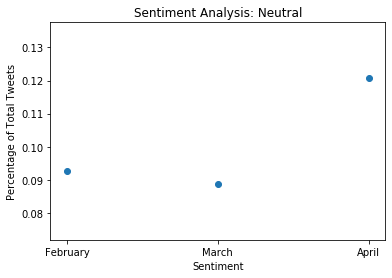

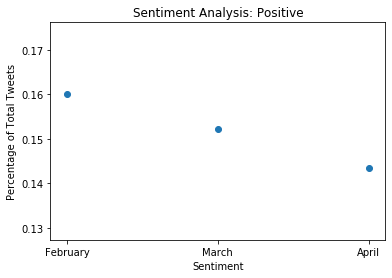

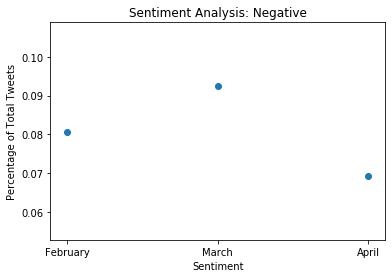

In [31]:
for sentiment in sentiments:
    month_percentages = []
    sentiment_tweets = data.loc[data["Analysis"] == sentiment]
    plt.title("Sentiment Analysis: " + sentiment)
    plt.xlabel("Sentiment")
    plt.ylabel("Percentage of Total Tweets")
    for month in months:
        month_tweets = sentiment_tweets.loc[sentiment_tweets["Month"] == month]
        month_percentages.append(month_tweets["Analysis"].value_counts()/data.shape[0])
    plt.scatter(months, month_percentages) 
    plt.show()

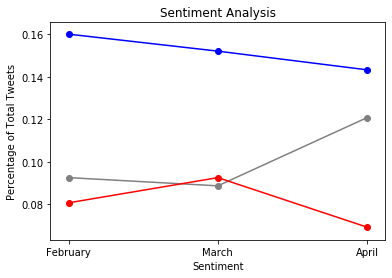

In [32]:
plt.title("Sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Percentage of Total Tweets")
    
for sentiment in sentiments:
    month_percentages = []
    sentiment_tweets = data.loc[data["Analysis"] == sentiment]
    for month in months:
        month_tweets = sentiment_tweets.loc[sentiment_tweets["Month"] == month]
        month_percentages.append(month_tweets["Analysis"].value_counts()/data.shape[0])
    plt.scatter(months, month_percentages, c = sentiment_colors[sentiment]) 
    plt.plot(months, month_percentages, c = sentiment_colors[sentiment])
plt.show()

## Naive Bayes Classification

### Training the model

In [33]:
corpus = pd.read_csv("Data/full_corpus.csv")

corpus["TweetText"] = corpus["TweetText"].apply(cleanText)
corpus["List of Words"] = corpus["TweetText"].apply(convertToList)

In [34]:
corpus.head()

,Topic,Sentiment,TweetId,TweetDate,TweetText,List of Words
0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,now all has to do is get swype on the iphone ...,"[get, swype, iphone, crack, iphone]"
1,apple,positive,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,will be adding more carrier support to the ip...,"[adding, carrier, support, iphone, 4s, announced]"
2,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,hilarious video - guy does a duet with 's si...,"[hilarious, video, guy, duet, 's, siri, pretty..."
3,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,you made it too easy for me to switch to iph...,"[made, easy, switch, iphone, see, ya]"
4,apple,positive,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,i just realized that the reason i got into twi...,"[realized, reason, got, twitter, ios5, thanks]"


In [35]:
training_data, testing_data = train_test_split(corpus, test_size = 0.2)

print(corpus.shape)
print(training_data.shape)
print(testing_data.shape)

(5113, 6)
(4090, 6)
(1023, 6)


In [36]:
training_data_list = []
for index, row in training_data.iterrows():
    training_data_list.append((row["TweetText"], row["Sentiment"]))

testing_data_list = []
for index, row in testing_data.iterrows():
    testing_data_list.append((row["TweetText"], row["Sentiment"]))

In [37]:
# This function was adapted from https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed
# (The resource above is open source).
def build(data):
    world_list = []
    
    for (words, sentiment) in data:
        world_list.extend(words)

    words = nltk.FreqDist(world_list)
    word_features = words.keys()
    
    return word_features

In [38]:
# This function was adapted from https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed
# (The resource above is open source).
def get_features(text):
    words = set(text)
    features = {}
    
    for word in word_features:
        features['contains(%s)' % word] = (word in words)
        
    return features 

In [39]:
word_features = build(training_data_list)
training_features=nltk.classify.apply_features(get_features, training_data_list)

In [40]:
NBayesClassifier = nltk.NaiveBayesClassifier.train(training_features)

In [41]:
# This piece of code was suggested in https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed
NBResultLabels = [NBayesClassifier.classify(get_features(tweet[0])) for tweet in testing_data_list]


In [42]:
print("Percentage of Positive Sentiments:", NBResultLabels.count('positive') / testing_data.shape[0])
print()
print("Percentage of Negative Sentiments:", NBResultLabels.count('negative') / testing_data.shape[0])


Percentage of Positive Sentiments: 0.013685239491691105

Percentage of Negative Sentiments: 0.05865102639296188


### Applying the Model to Covid-19 Twitter Data

In [43]:
training_data, testing_data = train_test_split(data, test_size = 0.2)

In [44]:
print(data.shape)
print(training_data.shape)
print(testing_data.shape)

(7500, 7)
(6000, 7)
(1500, 7)


In [45]:
word_features = build(training_data_list)
training_features=nltk.classify.apply_features(get_features, training_data_list)

In [46]:
NBayesClassifier = nltk.NaiveBayesClassifier.train(training_features)

In [47]:
# This piece of code was suggested in https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed
NBResultLabels = [NBayesClassifier.classify(get_features(tweet[0])) for tweet in testing_data_list]

In [48]:
print("Percentage of Positive Sentiments:", NBResultLabels.count('positive') / testing_data.shape[0])
print()
print("Percentage of Negative Sentiments:", NBResultLabels.count('negative') / testing_data.shape[0])

Percentage of Positive Sentiments: 0.009333333333333334

Percentage of Negative Sentiments: 0.04


## Moving Forward...

I plan to continue using this model to investigate how the positive/negative sentiment in Tweets changes over time and whether this has any correlation to the number of cases/deaths in the US.